# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [45]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

## Data preparation

In [46]:
# Check basic dataset information
print("Dataset Info:")
print(df.info())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-

In [47]:
# Remove duplicates
df_deduplicated = df.drop_duplicates()

print(f"\nNumber of rows after removing duplicates: {df_deduplicated.shape[0]}")
print(f"Removed {df.shape[0] - df_deduplicated.shape[0]} duplicate rows.")
df_deduplicated.duplicated().sum()  


Number of rows after removing duplicates: 60923
Removed 146 duplicate rows.


0

After removing 146 duplicate rows, our dataset is now cleaner and avoids potential biases from repeated observations.

In [48]:
# Check class distribution
class_distribution = df_deduplicated['class'].value_counts()
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
class
p    33742
e    27181
Name: count, dtype: int64


The dataset shows a well-balanced distribution between edible and poisonous mushrooms, which is ideal for training as it prevents class bias.

In [49]:
import pandas as pd

# Check for missing values
missing_values = df_deduplicated.isnull().sum()
missing_pct = round((missing_values / len(df_deduplicated)) * 100, 2)
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_pct})
missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)
print("Missing values in each column:")
print(missing_data)


Missing values in each column:
                   Missing Values  Percentage
veil-type                   57746       94.79
spore-print-color           54597       89.62
veil-color                  53510       87.83
stem-root                   51536       84.59
stem-surface                38122       62.57
gill-spacing                25062       41.14
cap-surface                 14120       23.18
gill-attachment              9855       16.18
ring-type                    2471        4.06


There is some features that have missing values. Some of them are a bigger part of te dataset and some are a small percentage.
Removing features with a lot of missing values can hopefully reduce noice and make our model perform better.

In [50]:
MISSING_THRESHOLD = 90.0 
# drop columns with too many missing values
cols_to_drop = missing_data[missing_data['Percentage'] > MISSING_THRESHOLD].index
df_clean = df_deduplicated.drop(columns=cols_to_drop)


# Verify what is left after
print("\nMissing values after dropping columns:")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


Missing values after dropping columns:
cap-surface          14120
gill-attachment       9855
gill-spacing         25062
stem-root            51536
stem-surface         38122
veil-color           53510
ring-type             2471
spore-print-color    54597
dtype: int64


We decided to move on with most of the features(90% treshold), because after removing them with 60% treshold, the models were performing worse.

It seems weird that it happens, so we quickly used random forest to check if maybe some of the removed features were actually important, even though they had a lot of missing values.

In [51]:
from sklearn.ensemble import RandomForestClassifier
# Use Random Forest on original data to check feature importance
rf = RandomForestClassifier(random_state=42)
# Handle missing values with a special category
df_with_missing = df.fillna('MISSING')
X_with_missing = pd.get_dummies(df_with_missing.drop('class', axis=1))
rf.fit(X_with_missing, df_with_missing['class'])

importance = pd.DataFrame({
    'feature': X_with_missing.columns,
    'importance': rf.feature_importances_
})
print("\nTop 10 important features:")
print(importance.sort_values('importance', ascending=False).head(10))



Top 10 important features:
                 feature  importance
2             stem-width    0.079173
0           cap-diameter    0.049034
1            stem-height    0.045503
86          stem-color_w    0.033454
46        gill-spacing_d    0.023101
41     gill-attachment_p    0.020281
45        gill-spacing_c    0.020273
58          gill-color_w    0.019407
44  gill-spacing_MISSING    0.019060
66  stem-surface_MISSING    0.018907


And as suspected, some of the features with a lot of missing values made it to the top, thus we decided to keep them.

In [52]:
X = df_clean.drop('class', axis=1)
y = df_clean['class']

In [53]:
from sklearn.preprocessing import LabelEncoder
# We need to encode categorical variables before modeling
le = LabelEncoder()

y_encoded = le.fit_transform(y)

print(f"\nTarget encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")



Target encoding: {'e': 0, 'p': 1}


In [54]:
le_dict = {}
X_onehot = pd.get_dummies(X, drop_first=True, dtype=int)

print(f"Original features: {X.shape[1]}")
print(f"One-hot encoded features: {X_onehot.shape[1]}")
print(f"\nDataset shape: {X_onehot.shape}")
print("\nFirst few encoded feature names:")
print(X_onehot.columns[:15].tolist())

X_onehot.head()

Original features: 19
One-hot encoded features: 102

Dataset shape: (60923, 102)

First few encoded feature names:
['cap-diameter', 'stem-height', 'stem-width', 'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p', 'cap-shape_s', 'cap-shape_x', 'cap-surface_e', 'cap-surface_g', 'cap-surface_h', 'cap-surface_i', 'cap-surface_k', 'cap-surface_l']


,cap-diameter,stem-height,stem-width,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_e,cap-surface_g,cap-surface_h,cap-surface_i,cap-surface_k,cap-surface_l,cap-surface_s,cap-surface_t,cap-surface_w,cap-surface_y,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,does-bruise-or-bleed_t,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_p,gill-attachment_s,gill-attachment_x,gill-spacing_d,gill-spacing_f,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-root_c,stem-root_f,stem-root_r,stem-root_s,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-color_e,stem-color_f,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,veil-color_k,veil-color_n,veil-color_u,veil-color_w,veil-color_y,has-ring_t,ring-type_f,ring-type_g,ring-type_l,ring-type_m,ring-type_p,ring-type_r,ring-type_z,spore-print-color_k,spore-print-color_n,spore-print-color_p,spore-print-color_r,spore-print-color_u,spore-print-color_w,habitat_g,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_s,season_u,season_w
0,15.26,16.95,17.09,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,16.60,17.99,18.19,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,14.07,17.80,17.74,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,14.17,15.77,15.98,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,14.64,16.53,17.20,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Now we have to scale and divide the data

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    X_onehot, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Now we will start modelling, starting with logistic regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the model
log_reg = LogisticRegression(random_state=42, max_iter=3000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

print("Training Logistic Regression with GridSearchCV...")
print(f"Testing {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver'])} combinations")

# Validation Methodology 1: GridSearchCV with 5-fold Cross-Validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # Prioritize recall to minimize false negatives (poisonous classified as edible)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation recall score: {grid_search.best_score_:.4f}")

Training Logistic Regression with GridSearchCV...
Testing 1 combinations
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation recall score: 0.8470


We're gonna now try to adjust the threshold to hopefully get more recall on poisonous mushrooms - since that is what's most important.
In short: lowering threshold -> higher recall (catch more poisonous) -> more false positives. 

In [57]:
best_log_reg = grid_search.best_estimator_

probs_train = best_log_reg.predict_proba(X_train_scaled)[:, 1]
probs_test = best_log_reg.predict_proba(X_test_scaled)[:, 1]

threshold = 0.3
y_train_thresh = (probs_train >= threshold).astype(int)
y_test_thresh = (probs_test >= threshold).astype(int)

print(f"\n=== Metrics with threshold={threshold} — TRAIN ===")
print(classification_report(y_train, y_train_thresh, target_names=['Edible','Poisonous']))
lrt_train_cm = confusion_matrix(y_train, y_train_thresh)
print("Confusion matrix (train):\n", lrt_train_cm)

print(f"\n=== Metrics with threshold={threshold} — TEST ===")
print(classification_report(y_test, y_test_thresh, target_names=['Edible','Poisonous']))
lrt_test_cm = confusion_matrix(y_test, y_test_thresh)
print("Confusion matrix (test):\n", lrt_test_cm)


=== Metrics with threshold=0.3 — TRAIN ===
              precision    recall  f1-score   support

      Edible       0.89      0.54      0.67     21745
   Poisonous       0.72      0.94      0.81     26993

    accuracy                           0.76     48738
   macro avg       0.80      0.74      0.74     48738
weighted avg       0.79      0.76      0.75     48738

Confusion matrix (train):
 [[11645 10100]
 [ 1490 25503]]

=== Metrics with threshold=0.3 — TEST ===
              precision    recall  f1-score   support

      Edible       0.89      0.53      0.67      5436
   Poisonous       0.71      0.95      0.82      6749

    accuracy                           0.76     12185
   macro avg       0.80      0.74      0.74     12185
weighted avg       0.79      0.76      0.75     12185

Confusion matrix (test):
 [[2881 2555]
 [ 347 6402]]


For the second model, we chose random forest as it does well with categorical values. It is also less prone to overfitting than single decision trees and can capture non-linear relationships.

Random forest can handle missing values, categorical variables without one-hot encoding  unscaled data, but we'll use our prepared dataset for consistency and a fair comparison with logistic regression.

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Grid search with focus on recall
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='recall',  # Same as logistic regression to prioritize catching poisonous mushrooms
    n_jobs=-1,
    verbose=1
)

# Fit the model
rf_grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters:", rf_grid_search.best_params_)

# feature importance
feature_importance = pd.DataFrame({
    'feature': X_onehot.columns,
    'importance': rf_grid_search.best_estimator_.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 important features from Random Forest:")
print(feature_importance.head(10))

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100}

Top 10 important features from Random Forest:
              feature  importance
2          stem-width    0.106552
1         stem-height    0.064057
0        cap-diameter    0.062033
71       stem-color_w    0.044627
85        ring-type_z    0.041148
34  gill-attachment_p    0.028623
37     gill-spacing_d    0.028589
52        stem-root_r    0.027560
54     stem-surface_g    0.027248
13      cap-surface_k    0.022702


We will add a third model which will be the stochastic gradient decent 

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42, max_iter=1000)

sgd_param_grid = {
    'loss': ['hinge', 'log_loss'],  
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.1]  # Learning rate (used when learning_rate='constant')
}

sgd_grid_search = GridSearchCV(
    estimator=sgd,
    param_grid=sgd_param_grid,
    cv=5,
    scoring='recall', 
    n_jobs=-1,
    verbose=1
)

sgd_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {sgd_grid_search.best_params_}")
print(f"Best cross-validation recall score: {sgd_grid_search.best_score_:.4f}")

# Get best model
best_sgd = sgd_grid_search.best_estimator_

# Make predictions
sgd_y_pred_train = best_sgd.predict(X_train_scaled)
sgd_y_pred = best_sgd.predict(X_test_scaled)

print("\n=== SGD Performance ===")
print("\nTraining Set:")
print(classification_report(y_train, sgd_y_pred_train, target_names=['Edible', 'Poisonous']))

print("\nTest Set:")
print(classification_report(y_test, sgd_y_pred, target_names=['Edible', 'Poisonous']))

sgd_cm = confusion_matrix(y_test, sgd_y_pred)


Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best parameters: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
Best cross-validation recall score: 0.8464

=== SGD Performance ===

Training Set:
              precision    recall  f1-score   support

      Edible       0.82      0.85      0.83     21745
   Poisonous       0.88      0.84      0.86     26993

    accuracy                           0.85     48738
   macro avg       0.85      0.85      0.85     48738
weighted avg       0.85      0.85      0.85     48738


Test Set:
              precision    recall  f1-score   support

      Edible       0.82      0.85      0.83      5436
   Poisonous       0.87      0.85      0.86      6749

    accuracy                           0.85     12185
   macro avg       0.85      0.85      0.85     12185
weighted avg       0.85      0.85      0.85     12185



In [60]:
# Get training predictions
rf_y_pred_train = rf_grid_search.predict(X_train_scaled)
rf_y_pred = rf_grid_search.predict(X_test_scaled)

# Compare training and test metrics
print("\n=== Random Forest Performance ===")
print("\nTraining Set:")
print(classification_report(y_train, rf_y_pred_train, target_names=['Edible', 'Poisonous']))

print("\nTest Set:")
print(classification_report(y_test, rf_y_pred, target_names=['Edible', 'Poisonous']))

# Print model complexity parameters
best_rf = rf_grid_search.best_estimator_
print("\nModel Complexity:")
print(f"Number of trees: {best_rf.n_estimators}")
print(f"Maximum depth: {best_rf.max_depth}")
print(f"Number of nodes: {sum(tree.tree_.node_count for tree in best_rf.estimators_)}")


=== Random Forest Performance ===

Training Set:
              precision    recall  f1-score   support

      Edible       0.91      0.98      0.95     21745
   Poisonous       0.98      0.93      0.95     26993

    accuracy                           0.95     48738
   macro avg       0.95      0.95      0.95     48738
weighted avg       0.95      0.95      0.95     48738


Test Set:
              precision    recall  f1-score   support

      Edible       0.92      0.98      0.95      5436
   Poisonous       0.98      0.93      0.95      6749

    accuracy                           0.95     12185
   macro avg       0.95      0.95      0.95     12185
weighted avg       0.95      0.95      0.95     12185


Model Complexity:
Number of trees: 100
Maximum depth: 10
Number of nodes: 20516


In [61]:
best_log_reg = grid_search.best_estimator_

# Make predictions
y_pred_train = best_log_reg.predict(X_train_scaled)
y_pred_test = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression Performance ===")
print("\nTraining Set:")
print(classification_report(y_train, y_pred_train, target_names=['Edible', 'Poisonous']))

print("\nTest Set:")
print(classification_report(y_test, y_pred_test, target_names=['Edible', 'Poisonous']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")



=== Logistic Regression Performance ===

Training Set:
              precision    recall  f1-score   support

      Edible       0.82      0.83      0.83     21745
   Poisonous       0.86      0.85      0.86     26993

    accuracy                           0.84     48738
   macro avg       0.84      0.84      0.84     48738
weighted avg       0.84      0.84      0.84     48738


Test Set:
              precision    recall  f1-score   support

      Edible       0.82      0.83      0.83      5436
   Poisonous       0.86      0.86      0.86      6749

    accuracy                           0.84     12185
   macro avg       0.84      0.84      0.84     12185
weighted avg       0.84      0.84      0.84     12185

Accuracy: 0.8443


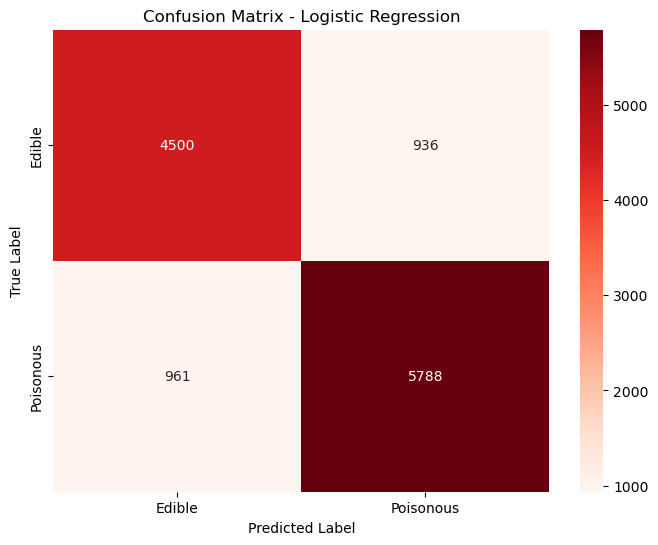

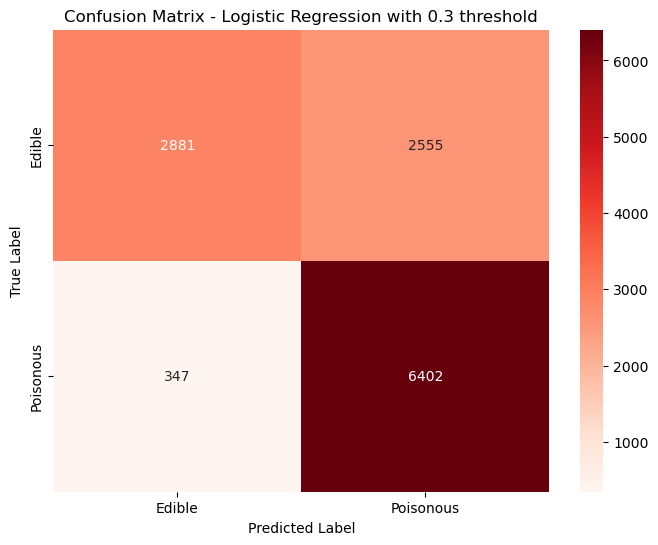

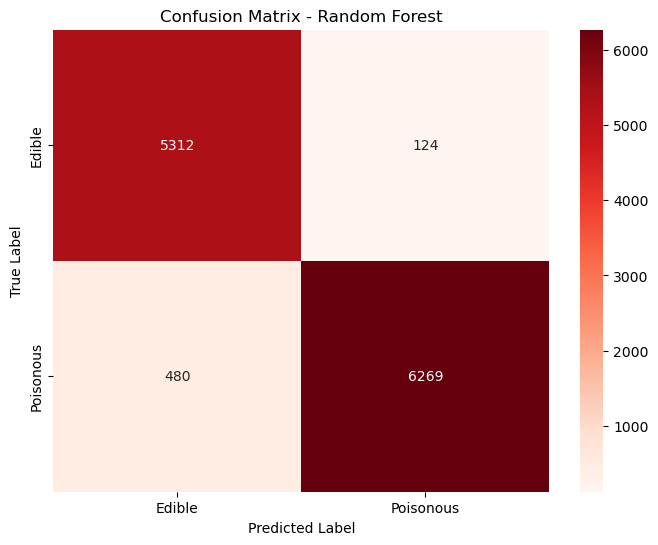

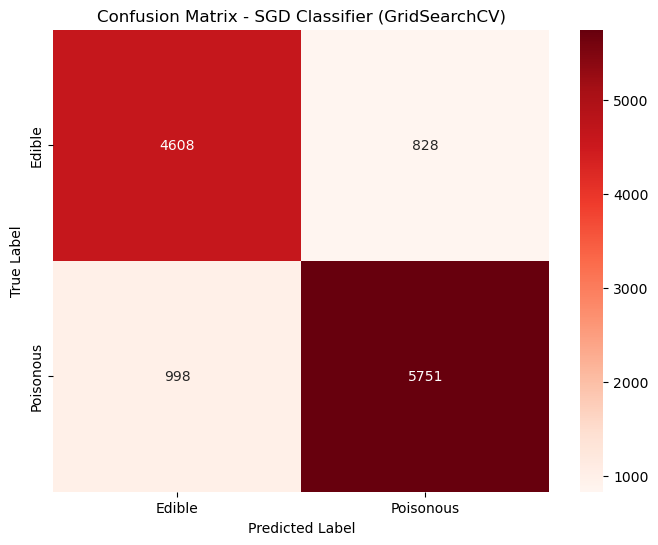


Confusion Matrix Analysis - SGD (GridSearchCV):
True Negatives (Edible correctly classified): 4608
False Positives (Edible wrongly classified as Poisonous): 828
False Negatives (Poisonous wrongly classified as Edible): 998  DANGEROUS!
True Positives (Poisonous correctly classified): 5751


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(lrt_test_cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression with 0.3 threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

rf_cm = confusion_matrix(y_test, rf_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(sgd_cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - SGD Classifier (GridSearchCV)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nConfusion Matrix Analysis - SGD (GridSearchCV):")
print(f"True Negatives (Edible correctly classified): {sgd_cm[0,0]}")
print(f"False Positives (Edible wrongly classified as Poisonous): {sgd_cm[0,1]}")
print(f"False Negatives (Poisonous wrongly classified as Edible): {sgd_cm[1,0]}  DANGEROUS!")
print(f"True Positives (Poisonous correctly classified): {sgd_cm[1,1]}")



### Performance Metrics explanation

#### Why Recall is Most Important for Mushroom Classification

For mushroom classification, Recall (Sensitivity) for the poisonous class is the most critical metric because false negatives are dangerous. 
Classifying a poisonous mushroom as edible could be fatal, thus we want to be as percise as possible. 

### Logistic regression:
From the test set results:

**Accuracy (~84%)**: Overall correctness, but doesn't capture the danger of false negatives.

**Precision for Poisonous (~86%)**: When we predict a mushroom is poisonous, we're correct 86% of the time. High precision means fewer false alarms.

**Recall for Poisonous (~86%)**: We correctly identify 86% of all poisonous mushrooms. This means **14% of poisonous mushrooms are misclassified as edible** - this is concerning!

**F1-Score (~0.86)**: Harmonic mean of precision and recall, providing a balanced measure.

### Interpretation

- Our model achieves 86% recall for poisonous mushrooms, meaning it catches most dangerous mushrooms
- However, the 14% false negative rate is still risky in a real-world scenario
- Ideally, we would want to:
  - Lower the classification threshold to increase recall (catch more poisonous mushrooms)
  - Accept more false positives (classify more as poisonous) to minimize danger
  - Aim for **recall > 95%** for the poisonous class

#### Threshold change

After chaning the threshold to 0.3 we get a decent ~95% recall on poisonous mushrooms. It is at a cost of recall for the edible ones but that was expected. Overall this solution gives us the best chance at catchting the most of dangerous mushrooms.

### Random forest:

Using random forest, we got impressive ~94% recall for poisonous mushrooms. It was difficult to adjust the parameters so the model is not completly overfitted, as it was 100% in most of the tries. But restricting the depth of the trees and other parameters allowed us to drop it a bit down.

Now it is around 94% for both train and test data.

It is a bit tricky to make a model that catches all/almost all poisonous mushrooms but that is also not overfitted at the same time.

### Stochastic Gradient Descent (SGD):

The SGD classifier achieved approximately **85% recall** for poisonous mushrooms, performing similarly to logistic regression. With 998 false negatives out of 12,185 test samples, this means **15% of poisonous mushrooms are misclassified as edible** 

**Key observations:**
- **Training and Test Performance**: Both sets show consistent ~85% recall, indicating the model generalizes well without overfitting
- **Balanced Performance**: Precision (87%) and recall (85%) are relatively balanced for the poisonous class
- **Computational Efficiency**: SGD converged quickly and is well-suited for large-scale datasets due to its iterative learning approach
- **Hyperparameter Sensitivity**: The model performed best with 'hinge' loss (SVM-like behavior), 'l2' penalty, and 'optimal' learning rate

While SGD offers computational advantages, its lower recall compared to Random Forest makes it less suitable for this safety-critical application where catching poisonous mushrooms is paramount.

In [63]:
## Validation Methodology 2: Train-Validation-Test Split

from sklearn.model_selection import train_test_split

# First split: separate test set (20%)
X_trainval, X_test_split, y_trainval, y_test_split = train_test_split(
    X_onehot, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Second split: separate validation set from training (20% of remaining 80% = 16% of total)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

scaler_split = StandardScaler()
X_train_split_scaled = scaler_split.fit_transform(X_train_split)
X_val_scaled = scaler_split.transform(X_val)
X_test_split_scaled = scaler_split.transform(X_test_split)

In [64]:
log_reg_manual = LogisticRegression(random_state=42, max_iter=1000)

C_values = [0.001, 0.01, 0.1, 1, 10, 50, 100]
val_scores = []

for C in C_values:
    log_reg_manual.set_params(C=C, penalty='l2')
    log_reg_manual.fit(X_train_split_scaled, y_train_split)
    val_score = log_reg_manual.score(X_val_scaled, y_val)
    val_scores.append(val_score)
    print(f"C={C}: Validation accuracy = {val_score:.4f}")

# Find best C
best_C = C_values[val_scores.index(max(val_scores))]

final_log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='saga', C=best_C, penalty='l2')
final_log_reg.fit(X_train_split_scaled, y_train_split)

train_score = final_log_reg.score(X_train_split_scaled, y_train_split)
val_score = final_log_reg.score(X_val_scaled, y_val)
test_score = final_log_reg.score(X_test_split_scaled, y_test_split)

print(f"\nFinal Model Performance:")
print(f"Training accuracy: {train_score:.4f}")
print(f"Validation accuracy: {val_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

y_pred_final = final_log_reg.predict(X_test_split_scaled)

print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_split, y_pred_final, target_names=['Edible', 'Poisonous']))

C=0.001: Validation accuracy = 0.8345
C=0.01: Validation accuracy = 0.8377
C=0.1: Validation accuracy = 0.8373
C=1: Validation accuracy = 0.8386
C=10: Validation accuracy = 0.8385
C=50: Validation accuracy = 0.8381
C=100: Validation accuracy = 0.8381

Final Model Performance:
Training accuracy: 0.8466
Validation accuracy: 0.8379
Test accuracy: 0.8466

=== Test Set Classification Report ===
              precision    recall  f1-score   support

      Edible       0.82      0.84      0.83      5436
   Poisonous       0.87      0.86      0.86      6749

    accuracy                           0.85     12185
   macro avg       0.84      0.85      0.85     12185
weighted avg       0.85      0.85      0.85     12185



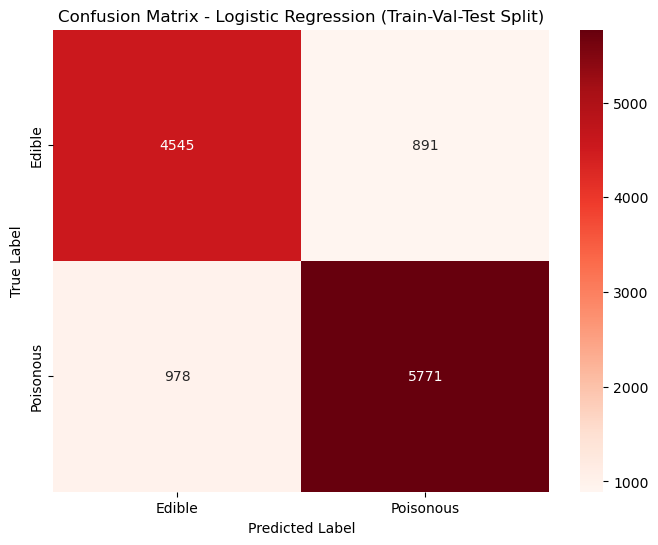

In [65]:
cm_split = confusion_matrix(y_test_split, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_split, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression (Train-Val-Test Split)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [66]:
print("\nConfusion Matrix Analysis (Train-Val-Test Split):")
print(f"True Negatives (Edible correctly classified): {cm_split[0,0]}")
print(f"False Positives (Edible wrongly classified as Poisonous): {cm_split[0,1]}")
print(f"False Negatives (Poisonous wrongly classified as Edible): {cm_split[1,0]}  DANGEROUS!")
print(f"True Positives (Poisonous correctly classified): {cm_split[1,1]}")


Confusion Matrix Analysis (Train-Val-Test Split):
True Negatives (Edible correctly classified): 4545
False Positives (Edible wrongly classified as Poisonous): 891
False Negatives (Poisonous wrongly classified as Edible): 978  DANGEROUS!
True Positives (Poisonous correctly classified): 5771


n_est=100, max_depth=5, min_split=10, min_leaf=5: Val Recall=0.7622, Val Acc=0.8125
n_est=100, max_depth=5, min_split=10, min_leaf=10: Val Recall=0.7644, Val Acc=0.8135
n_est=100, max_depth=5, min_split=20, min_leaf=5: Val Recall=0.7598, Val Acc=0.8107
n_est=100, max_depth=5, min_split=20, min_leaf=10: Val Recall=0.7644, Val Acc=0.8135
n_est=100, max_depth=10, min_split=10, min_leaf=5: Val Recall=0.9259, Val Acc=0.9499
n_est=100, max_depth=10, min_split=10, min_leaf=10: Val Recall=0.9129, Val Acc=0.9438
n_est=100, max_depth=10, min_split=20, min_leaf=5: Val Recall=0.9122, Val Acc=0.9440
n_est=100, max_depth=10, min_split=20, min_leaf=10: Val Recall=0.9129, Val Acc=0.9438
n_est=100, max_depth=15, min_split=10, min_leaf=5: Val Recall=0.9863, Val Acc=0.9921
n_est=100, max_depth=15, min_split=10, min_leaf=10: Val Recall=0.9846, Val Acc=0.9906
n_est=100, max_depth=15, min_split=20, min_leaf=5: Val Recall=0.9902, Val Acc=0.9939
n_est=100, max_depth=15, min_split=20, min_leaf=10: Val Recall=0

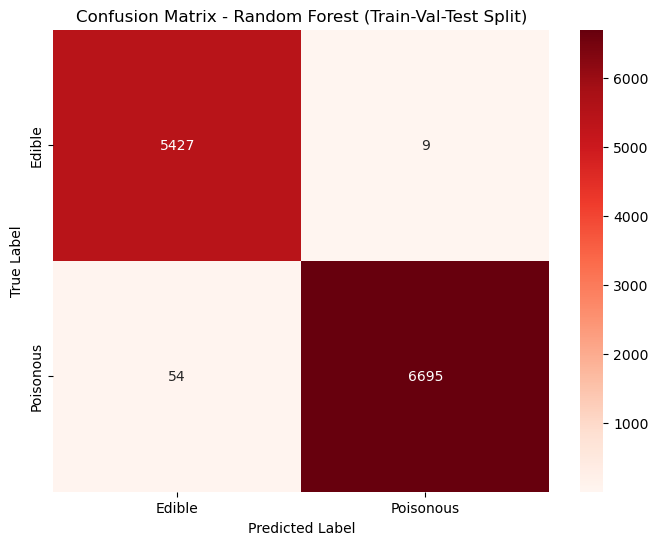


Confusion Matrix Analysis - Random Forest (Train-Val-Test Split):
True Negatives (Edible correctly classified): 5427
False Positives (Edible wrongly classified as Poisonous): 9
False Negatives (Poisonous wrongly classified as Edible): 54  DANGEROUS!
True Positives (Poisonous correctly classified): 6695


In [67]:
#Validation Methodology 2 : Train-Validation-Test Split Random Forest
n_estimators_values = [100]
max_depth_values = [5, 10, 15]
min_samples_split_values = [10, 20]
min_samples_leaf_values = [5, 10]


val_scores_rf = []
param_combinations = []

rf_manual = RandomForestClassifier(random_state=42)

for n_est in n_estimators_values:
    for max_d in max_depth_values:
        for min_split in min_samples_split_values:
            for min_leaf in min_samples_leaf_values:
                rf_manual.set_params(
                    n_estimators=n_est,
                    max_depth=max_d,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    max_features='sqrt',
                    class_weight='balanced'
                )
                
                rf_manual.fit(X_train_split_scaled, y_train_split)
                
                # Evaluate on validation set
                val_pred = rf_manual.predict(X_val_scaled)
                val_recall = recall_score(y_val, val_pred)
                val_accuracy = rf_manual.score(X_val_scaled, y_val)
                
                val_scores_rf.append(val_recall)
                param_combinations.append({
                    'n_estimators': n_est,
                    'max_depth': max_d,
                    'min_samples_split': min_split,
                    'min_samples_leaf': min_leaf,
                    'val_recall': val_recall,
                    'val_accuracy': val_accuracy
                })
                
                print(f"n_est={n_est}, max_depth={max_d}, min_split={min_split}, min_leaf={min_leaf}: "
                      f"Val Recall={val_recall:.4f}, Val Acc={val_accuracy:.4f}")

# Find best parameters based on recall
best_idx = val_scores_rf.index(max(val_scores_rf))
best_params_rf = param_combinations[best_idx]

print(f"Best parameters based on validation recall:")
print(f"  n_estimators: {best_params_rf['n_estimators']}")
print(f"  max_depth: {best_params_rf['max_depth']}")
print(f"  min_samples_split: {best_params_rf['min_samples_split']}")
print(f"  min_samples_leaf: {best_params_rf['min_samples_leaf']}")
print(f"  Validation Recall: {best_params_rf['val_recall']:.4f}")
print(f"  Validation Accuracy: {best_params_rf['val_accuracy']:.4f}")

final_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features='sqrt',
    class_weight='balanced'
)
final_rf.fit(X_train_split_scaled, y_train_split)

rf_train_pred = final_rf.predict(X_train_split_scaled)
rf_val_pred = final_rf.predict(X_val_scaled)
rf_test_pred = final_rf.predict(X_test_split_scaled)

train_score_rf = final_rf.score(X_train_split_scaled, y_train_split)
val_score_rf = final_rf.score(X_val_scaled, y_val)
test_score_rf = final_rf.score(X_test_split_scaled, y_test_split)

print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_split, rf_test_pred, target_names=['Edible', 'Poisonous']))

rf_cm_split = confusion_matrix(y_test_split, rf_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_split, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Random Forest (Train-Val-Test Split)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nConfusion Matrix Analysis - Random Forest (Train-Val-Test Split):")
print(f"True Negatives (Edible correctly classified): {rf_cm_split[0,0]}")
print(f"False Positives (Edible wrongly classified as Poisonous): {rf_cm_split[0,1]}")
print(f"False Negatives (Poisonous wrongly classified as Edible): {rf_cm_split[1,0]}  DANGEROUS!")
print(f"True Positives (Poisonous correctly classified): {rf_cm_split[1,1]}")



Tuning SGD hyperparameters using validation set:
--------------------------------------------------------------------------------
loss=hinge, penalty=l2, alpha=0.0001, lr=optimal: Val Recall=0.8205, Val Acc=0.8347
loss=hinge, penalty=l2, alpha=0.0001, lr=constant: Val Recall=0.8120, Val Acc=0.8192
loss=hinge, penalty=l2, alpha=0.001, lr=optimal: Val Recall=0.8366, Val Acc=0.8407
loss=hinge, penalty=l2, alpha=0.001, lr=constant: Val Recall=0.8024, Val Acc=0.8174
loss=hinge, penalty=l2, alpha=0.01, lr=optimal: Val Recall=0.8320, Val Acc=0.8416
loss=hinge, penalty=l2, alpha=0.01, lr=constant: Val Recall=0.8055, Val Acc=0.8125
loss=hinge, penalty=l1, alpha=0.0001, lr=optimal: Val Recall=0.8548, Val Acc=0.8404
loss=hinge, penalty=l1, alpha=0.0001, lr=constant: Val Recall=0.8342, Val Acc=0.8192
loss=hinge, penalty=l1, alpha=0.001, lr=optimal: Val Recall=0.8322, Val Acc=0.8374
loss=hinge, penalty=l1, alpha=0.001, lr=constant: Val Recall=0.7896, Val Acc=0.8099
loss=hinge, penalty=l1, alpha=0.

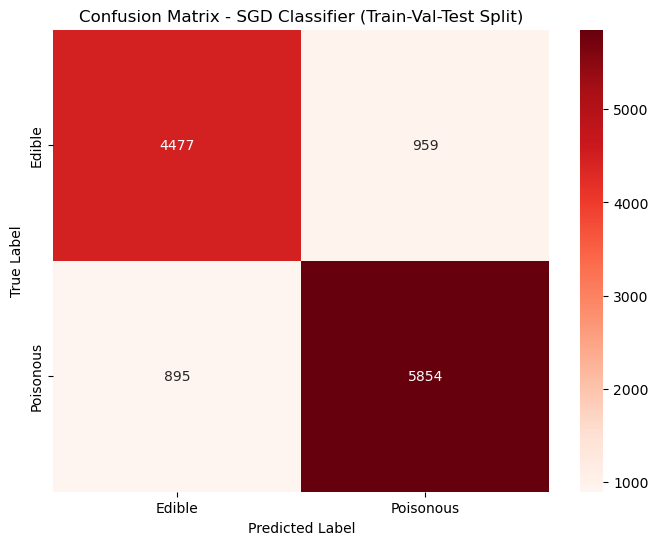

In [68]:
#Validation Methodology 2 Train-Validation-Test Split SGD

sgd_manual = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

# Define parameters to test
loss_values = ['hinge', 'log_loss']
penalty_values = ['l2', 'l1']
alpha_values = [0.0001, 0.001, 0.01]
learning_rate_values = ['optimal', 'constant']

val_scores_sgd = []
param_combinations_sgd = []

print("\nTuning SGD hyperparameters using validation set:")
print("-" * 80)

# Test different combinations
for loss in loss_values:
    for penalty in penalty_values:
        for alpha in alpha_values:
            for lr in learning_rate_values:
                try:
                    sgd_manual.set_params(
                        loss=loss,
                        penalty=penalty,
                        alpha=alpha,
                        learning_rate=lr,
                        eta0=0.01 if lr == 'constant' else 0.0
                    )
                    
                    sgd_manual.fit(X_train_split_scaled, y_train_split)
                    
                    # Evaluate on validation set
                    val_pred = sgd_manual.predict(X_val_scaled)
                    val_recall = recall_score(y_val, val_pred)
                    val_accuracy = sgd_manual.score(X_val_scaled, y_val)
                    
                    val_scores_sgd.append(val_recall)
                    param_combinations_sgd.append({
                        'loss': loss,
                        'penalty': penalty,
                        'alpha': alpha,
                        'learning_rate': lr,
                        'val_recall': val_recall,
                        'val_accuracy': val_accuracy
                    })
                    
                    print(f"loss={loss}, penalty={penalty}, alpha={alpha}, lr={lr}: "
                          f"Val Recall={val_recall:.4f}, Val Acc={val_accuracy:.4f}")
                
                except Exception as e:
                    print(f"Skipping combination: loss={loss}, penalty={penalty}, alpha={alpha}, lr={lr} - Error: {str(e)}")
                    continue

# Find best parameters based on recall
if val_scores_sgd:
    best_idx_sgd = val_scores_sgd.index(max(val_scores_sgd))
    best_params_sgd = param_combinations_sgd[best_idx_sgd]

    print("\n" + "="*80)
    print(f"Best parameters based on validation recall:")
    print(f"  loss: {best_params_sgd['loss']}")
    print(f"  penalty: {best_params_sgd['penalty']}")
    print(f"  alpha: {best_params_sgd['alpha']}")
    print(f"  learning_rate: {best_params_sgd['learning_rate']}")
    print(f"  Validation Recall: {best_params_sgd['val_recall']:.4f}")
    print(f"  Validation Accuracy: {best_params_sgd['val_accuracy']:.4f}")
    print("="*80)

    # Train final SGD model with best parameters
    final_sgd = SGDClassifier(
        random_state=42,
        max_iter=1000,
        tol=1e-3,
        loss=best_params_sgd['loss'],
        penalty=best_params_sgd['penalty'],
        alpha=best_params_sgd['alpha'],
        learning_rate=best_params_sgd['learning_rate'],
        eta0=0.01 if best_params_sgd['learning_rate'] == 'constant' else 0.0
    )

    final_sgd.fit(X_train_split_scaled, y_train_split)

    # Evaluate on all three sets
    sgd_train_pred = final_sgd.predict(X_train_split_scaled)
    sgd_val_pred = final_sgd.predict(X_val_scaled)
    sgd_test_pred = final_sgd.predict(X_test_split_scaled)

    train_score_sgd = final_sgd.score(X_train_split_scaled, y_train_split)
    val_score_sgd = final_sgd.score(X_val_scaled, y_val)
    test_score_sgd = final_sgd.score(X_test_split_scaled, y_test_split)

    print(f"\nFinal SGD Model Performance:")
    print(f"Training accuracy: {train_score_sgd:.4f}")
    print(f"Validation accuracy: {val_score_sgd:.4f}")
    print(f"Test accuracy: {test_score_sgd:.4f}")

    print("\n=== Test Set Classification Report ===")
    print(classification_report(y_test_split, sgd_test_pred, target_names=['Edible', 'Poisonous']))

    sgd_cm_split = confusion_matrix(y_test_split, sgd_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(sgd_cm_split, annot=True, fmt='d', cmap='Reds', 
                xticklabels=['Edible', 'Poisonous'], 
                yticklabels=['Edible', 'Poisonous'])
    plt.title('Confusion Matrix - SGD Classifier (Train-Val-Test Split)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

